In [150]:
import pandas as pd
from pandas.tools.plotting import table
pd.set_option('display.max_colwidth', -1)

import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import spacy
nlp = spacy.load('en')

import tweepy
import os
import six
import subprocess
import csv
import re
import time
import pickle
import preprocessor as p
import itertools
from collections import Counter
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

# Gathering Tweets with Twitter API (Tweepy)

In [3]:
keys = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/twitterkeys.csv')

In [4]:
ckey = keys.consumer_key[0]
csecret = keys.consumer_secret[0]
atoken = keys.access_token[0]
asecret = keys.access_secret[0]

auth = tweepy.OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)
api = tweepy.API(auth)

In [5]:
def get_tweets(user):    
    tweetlist = []
    tweets = api.user_timeline(screen_name=user, count=200, include_rts=False)
    tweetlist.extend(tweets)
    lastweet = tweetlist[-1].id-1
    
    while len(tweets) > 0:
        tweets = api.user_timeline(screen_name=user, count=200, include_rts=False, max_id=lastweet)
        tweetlist.extend(tweets)
        lastweet = tweetlist[-1].id-1
        print(len(tweetlist), ' downloaded so far')
    
    outtweets = [[tweet.text.encode('utf-8')] for tweet in tweetlist]
    print(outtweets)
    with open (' {}.csv'.format(user), 'w') as f:
        writer = csv.writer(f)
        writer.writerows('t')
        writer.writerows(outtweets)
#Code sourced from https://gist.github.com/yanofsky/5436496

get_tweets('justinbieber')

get_tweets('jtimberlake')
get_tweets('zaynmalik')
get_tweets('chrisbrown')
get_tweets('brunomars')
get_tweets('selenagomez')
get_tweets('ddlovato')
get_tweets('aliciakeys')
get_tweets('ladygaga')
get_tweets('katyperry')


In [6]:
jb = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/justinbieber.csv')
jt = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/jtimberlake.csv')
zm = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/zaynmalik.csv')
cb = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/chrisbrown.csv')
bm = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/brunomars.csv')
sg = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/selenagomez.csv')
dl = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/ddlovato.csv')
ak = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/aliciakeys.csv')
lg = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/ladygaga.csv')
kp = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/katyperry.csv')

In [7]:
jb['artist'] = 'justinbieber'
jt['artist'] = 'justintimberlake'
zm['artist'] = 'zaynmalik'
cb['artist'] = 'chrisbrown'
bm['artist'] = 'brunomars'
sg['artist'] = 'selenagomez'
dl['artist'] = 'demilovato'
ak['artist'] = 'aliciakeys'
lg['artist'] = 'ladygaga'
kp['artist'] = 'katyperry'

In [8]:
artistlist = ['justinbieber', 'justintimberlake', 'zaynmalik', 'chrisbrown', 'brunomars', 'selenagomez', 'demilovato',
             'aliciakeys', 'ladygaga', 'katyperry']

In [9]:
jb.head()

,t,artist
0,b'All love over here Aaron. You got my support',justinbieber
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber
3,b'3 years ago today released #Purpose. Thank you',justinbieber
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber


In [10]:
print(zm.t[0])

b'Thank you @Spotify \xf0\x9f\x99\x8c\xf0\x9f\x8f\xbd \nhttps://t.co/DUMWKSiGYN https://t.co/RlQhR0gRLR'


In [2]:
b'\xf0\x9f\x99\x8c\xf0\x9f\x8f\xbd'.decode()


'🙌🏽'

In [12]:
#Combine the tweets of all artists into one dataframe
alltweets = pd.concat([jb,jt,zm,cb,bm,sg,dl,ak,lg,kp])

In [13]:
#Preprocessor is a python package that preprocesses tweets by removing abundant useless information such as
#emojis urls and symbols.
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION)
alltweets['cleaned'] = alltweets['t'].apply(lambda x: p.clean(x))
alltweets.cleaned = alltweets.cleaned.str.lower()
alltweets.cleaned = alltweets.cleaned.str.strip()
alltweets.cleaned = alltweets.cleaned.str.replace("b'", '')
alltweets.cleaned = alltweets.cleaned.str.replace('b"', '')

In [14]:
#Preprocessor doesnt seem to remove all emojis, and our data is still rather dirty.
def removeemoji(text):
    clean = re.sub(r'\\', '', text)
    clean = re.sub(r'(x..){3,}','',clean)
    return clean

def GetSpecialChar(x):
    special_characters = []
    for char in x:
        if char.isalpha() == False:
            special_characters.append(char)
    return special_characters

special_characters = alltweets.cleaned.apply(lambda x: GetSpecialChar(x))
special_characters = list(set(itertools.chain.from_iterable(special_characters)))
special_characters.remove(' ')

alltweets.cleaned = alltweets.cleaned.apply(lambda x: removeemoji(x))
alltweets.cleaned = alltweets.cleaned.str.replace('\\n', '')
alltweets.cleaned = alltweets.cleaned.str.replace("can't", '')
alltweets.cleaned = alltweets.cleaned.str.replace("won't", '')
alltweets.cleaned = alltweets.cleaned.str.replace('\\nhttps:', '')
alltweets.cleaned = alltweets.cleaned.str.replace('https:', '')
alltweets.cleaned = alltweets.cleaned.str.replace('https://', '')
alltweets.cleaned = alltweets.cleaned.str.replace('\\n', '')
alltweets.cleaned = alltweets.cleaned.str.replace('https', '')
alltweets.cleaned = alltweets.cleaned.str.replace("n't", '')
alltweets.cleaned = alltweets.cleaned.str.replace("'t", '')
alltweets.cleaned = alltweets.cleaned.str.replace("'s", '')
alltweets.cleaned = alltweets.cleaned.str.replace("'re", '')
alltweets.cleaned = alltweets.cleaned.apply(lambda x: re.sub(r'(.)\1{3,}.*$', '', x)) #Removes words with 3+ repeating letters

for char in (special_characters):
    alltweets.cleaned = alltweets.cleaned.str.replace(char, '')
alltweets.cleaned = alltweets.cleaned.str.strip()

alltweets.head()

,t,artist,cleaned
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire


In [15]:
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
alltweets['tokenized'] = alltweets.cleaned.apply(lambda x: word_tokenize(x))
def removestop(x):
    newlist = []
    for w in x:
        if w not in stopwords and len(w)>1: # Appends words w/ len >1 that are not stop-words to new tokenized list
            w = lem.lemmatize(w)
            newlist.append(w)
    return newlist

alltweets['tokenized'] = alltweets.tokenized.apply(lambda x: removestop(x))
alltweets.head()

,t,artist,cleaned,tokenized
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,"[love, aaron, got, support]"
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,"[aaron, carter, album, little, bumped, song, aaron, party, like, need, hype, man, got]"
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,"[xkarla, donate, portion, proceeds, humane, society, help, animal, hurt, displaced, fire]"
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,"[year, ago, today, released, purpose, thank]"
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,"[thank, next, bop, favorite, song, least, song, smash, fire]"


In [16]:
alltweets.tokenized = alltweets.tokenized.apply(lambda x: ' '.join(x))
alltweets.head()

,t,artist,cleaned,tokenized
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,love aaron got support
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,aaron carter album little bumped song aaron party like need hype man got
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,xkarla donate portion proceeds humane society help animal hurt displaced fire
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,year ago today released purpose thank
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,thank next bop favorite song least song smash fire


In [17]:
#Remove empty tweets
finaltweets = alltweets[(alltweets.tokenized !='')&(alltweets.tokenized!=' ')]
finaltweets.head()

,t,artist,cleaned,tokenized
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,love aaron got support
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,aaron carter album little bumped song aaron party like need hype man got
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,xkarla donate portion proceeds humane society help animal hurt displaced fire
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,year ago today released purpose thank
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,thank next bop favorite song least song smash fire


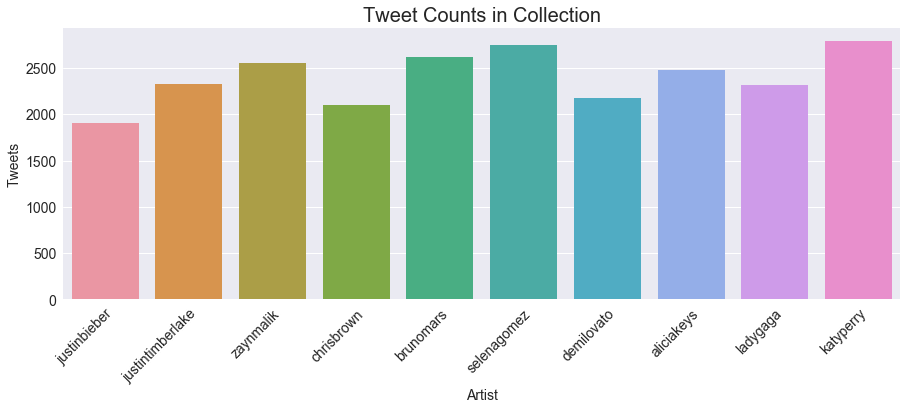

Tweets per Artist 

 katyperry           2797
selenagomez         2753
brunomars           2617
zaynmalik           2555
aliciakeys          2480
justintimberlake    2332
ladygaga            2316
demilovato          2174
chrisbrown          2096
justinbieber        1901
Name: artist, dtype: int64


In [18]:
plt.figure(figsize=(15,5))
sns.countplot(x=finaltweets.artist, data=finaltweets)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('Tweet Counts in Collection', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Artist', fontsize=14)
plt.ylabel('Tweets', fontsize=14)
plt.show()
print('Tweets per Artist','\n\n',finaltweets.artist.value_counts())

In [19]:
finaltweets['numwords'] = finaltweets.cleaned.apply(lambda x: len(x.split()))
finaltweets.head()

C:\Users\JChaotogo\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,t,artist,cleaned,tokenized,numwords
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,love aaron got support,9
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,aaron carter album little bumped song aaron party like need hype man got,28
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,xkarla donate portion proceeds humane society help animal hurt displaced fire,20
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,year ago today released purpose thank,7
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,thank next bop favorite song least song smash fire,15


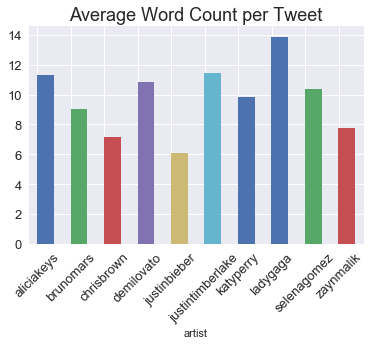

In [98]:
finaltweets.groupby('artist')['numwords'].mean().plot(kind='bar', rot=45, position=.01, grid=True)
plt.title('Average Word Count per Tweet', fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [21]:
#Gets the punctuation count to use as a feature.
def periodcount(x):
    n = 0
    for char in x:
        if char == '.':
            n+=1
    return n

def questioncount(x):
    n = 0
    for char in x:
        if char == '?':
            n+=1
    return n

def exclaimcount(x):
    n = 0
    for char in x:
        if char == '.':
            n+=1
    return n

def hashcount(x):
    n=0
    for char in x:
        if char == '#':
            n+=1
    return n

def mentioncount(x):
    n=0
    for char in x:
        if char == '@':
            n+=1
    return n

In [22]:
finaltweets['hashcount'] = finaltweets.t.apply(lambda x: hashcount(x))
finaltweets['mentioncount'] = finaltweets.t.apply(lambda x: mentioncount(x))

C:\Users\JChaotogo\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\JChaotogo\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
finaltweets.head()

,t,artist,cleaned,tokenized,numwords,hashcount,mentioncount
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,love aaron got support,9,0,0
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,aaron carter album little bumped song aaron party like need hype man got,28,0,0
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,xkarla donate portion proceeds humane society help animal hurt displaced fire,20,0,0
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,year ago today released purpose thank,7,1,0
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,thank next bop favorite song least song smash fire,15,0,0


# Word2Vec Implementation

In [80]:
alltweets.head()

,t,artist,cleaned,tokenized
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,love aaron got support
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,aaron carter album little bumped song aaron party like need hype man got
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,xkarla donate portion proceeds humane society help animal hurt displaced fire
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,year ago today released purpose thank
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,thank next bop favorite song least song smash fire


In [81]:
tweetlist = ' '.join(alltweets.cleaned[:12000])

In [82]:
tweetlist2 = ' '.join(alltweets.cleaned[12000:])

In [83]:
tweetlist[0:200]

'all love over here aaron you got my support aaron carter i had your album when i was little and bumped the song aarons party i was like  if you need a hype man i got you xkarla will donate a portion o'

In [84]:
len(tweetlist)

499007

In [85]:
tweetlist_doc = nlp(tweetlist)

In [86]:
tweetlist_doc2 = nlp(tweetlist2)

In [87]:
tweets = []
for tweet in tweetlist_doc.sents:
    tweet = [token.lemma_.lower() for token in tweet if not token.is_stop
            and not token.is_punct]
    tweets.append(tweet)
    
for tweet in tweetlist_doc2.sents:
    tweet = [token.lemma_.lower() for token in tweet if not token.is_stop
            and not token.is_punct]
    tweets.append(tweet)
print (tweets[20])
print('We have {} sentences and {} tokens.'.format(len(tweets), len(tweetlist_doc)
                                                   +len(tweetlist_doc2)))

['lyric', 'video', 'friend', 'friend', ' ', 'new', 'song', 'friend', 'hour', 'friend', 'new', 'music', 'thursday', 'noon']
We have 14336 sentences and 248719 tokens.


In [88]:
import gensim
from gensim.models import word2vec

start = time.time()
model = word2vec.Word2Vec(tweets, workers=4, min_count=10, window=6, sg=0, 
                         sample=.001, size=300, hs=1)
print(time.time()-start)

C:\Users\JChaotogo\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


2.755990743637085


In [211]:
vocab = model.wv.vocab.keys()
print(model.wv.most_similar(positive=['teamjt']))

[('theexperience', 0.8859345316886902), ('jttour', 0.8438752889633179), ('pm', 0.8246660232543945), ('iheartradio', 0.8101329803466797), ('pt', 0.7862127423286438), ('perform', 0.7862002849578857), ('jt', 0.7843164205551147), ('finale', 0.7816487550735474), ('kpwww', 0.7796887159347534), ('katy', 0.7792980670928955)]


In [213]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

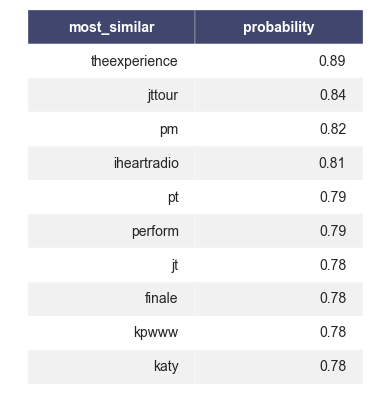

In [219]:
jtex = pd.DataFrame(model.wv.most_similar(positive=['teamjt']), columns = ['most_similar', 'probability'])
jtex.probability = ['{:g}'.format(float('{:.2g}'.format(i))) for i in jtex.probability]
render_mpl_table(jtex)

In [157]:
wvsong = pd.DataFrame(model.wv.most_similar(positive=['song']), columns = ['most_similar', 'probability'])

In [216]:
wvsong.probability = ['{:g}'.format(float('{:.2g}'.format(i))) for i in wvsong.probability]

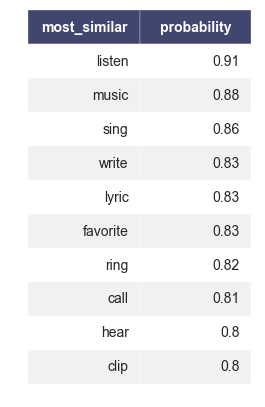

In [217]:
render_mpl_table(wvsong, header_columns=0, col_width=2.0)

The words to vec model doesn't give us accurate similarities most likely because of the small corpus. Some common words aren't represented in the vocabulary. However, this corpus could be helpful when added to a much larger model in order to add information about these artists as well as a slice of the music industry.

In [91]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import path
from PIL import Image

In [92]:
jb = ' '.join(finaltweets[finaltweets.artist=='justinbieber']['tokenized'])
jt = ' '.join(finaltweets[finaltweets.artist=='justintimberlake']['tokenized'])
zm = ' '.join(finaltweets[finaltweets.artist=='zaynmalik']['tokenized'])
cb = ' '.join(finaltweets[finaltweets.artist=='chrisbrown']['tokenized'])
bm = ' '.join(finaltweets[finaltweets.artist=='brunomars']['tokenized'])
sg = ' '.join(finaltweets[finaltweets.artist=='selenagomez']['tokenized'])
dl = ' '.join(finaltweets[finaltweets.artist=='demilovato']['tokenized'])
ak = ' '.join(finaltweets[finaltweets.artist=='aliciakeys']['tokenized'])
lg = ' '.join(finaltweets[finaltweets.artist=='ladygaga']['tokenized'])
kp = ' '.join(finaltweets[finaltweets.artist=='katyperry']['tokenized'])

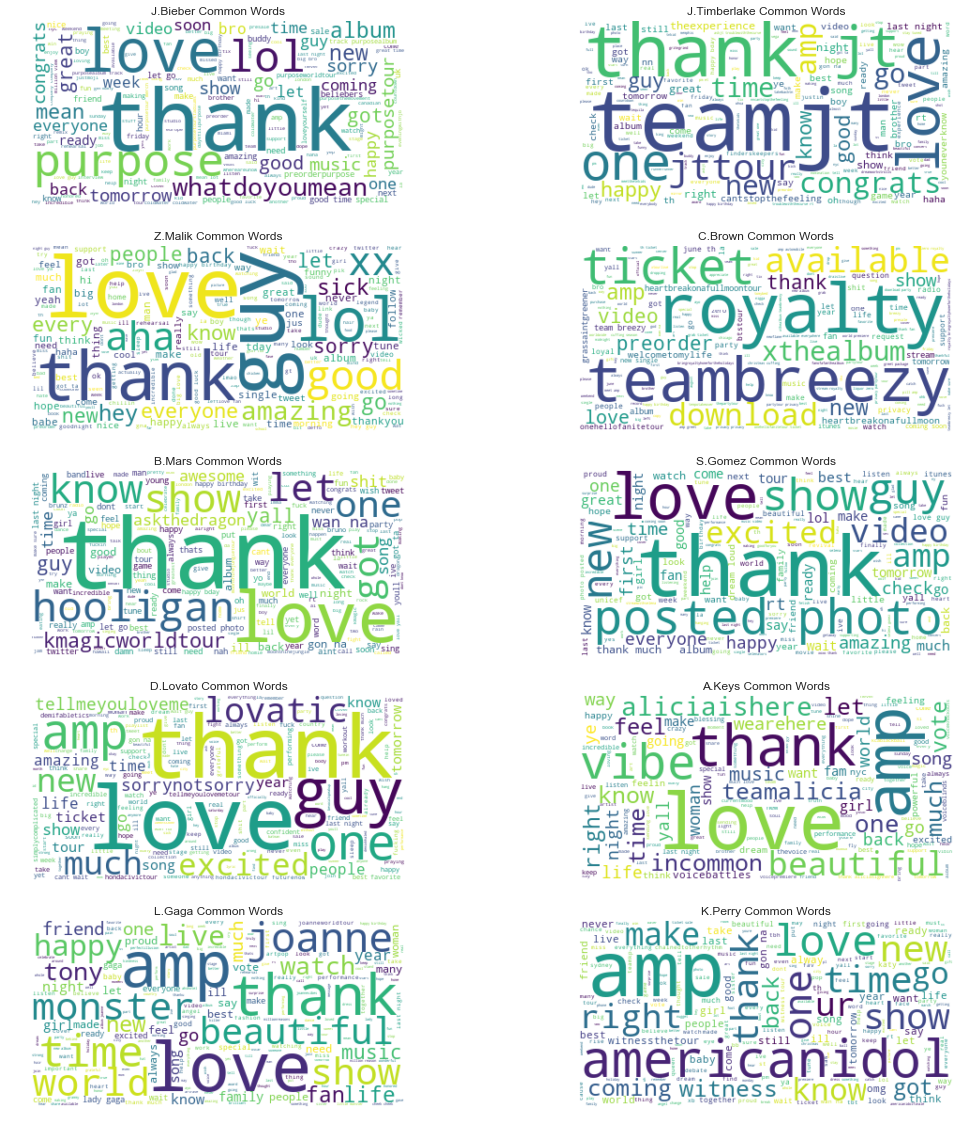

In [93]:
stopwords = set(STOPWORDS)
stopwords.update(['im', 'ha', 'see', 'today', 'tonight', 'day'])
jbw = WordCloud(stopwords=stopwords, background_color='white').generate(jb)
jtw = WordCloud(stopwords=stopwords, background_color='white').generate(jt)
zmw = WordCloud(stopwords=stopwords, background_color='white').generate(zm)
cbw = WordCloud(stopwords=stopwords, background_color='white').generate(cb)
bmw = WordCloud(stopwords=stopwords, background_color='white').generate(bm)
sgw = WordCloud(stopwords=stopwords, background_color='white').generate(sg)
dlw = WordCloud(stopwords=stopwords, background_color='white').generate(dl)
akw = WordCloud(stopwords=stopwords, background_color='white').generate(ak)
lgw = WordCloud(stopwords=stopwords, background_color='white').generate(lg)
kpw = WordCloud(stopwords=stopwords, background_color='white').generate(kp)

plt.figure(figsize=(18,20))
plt.subplot(5,2,1)
plt.imshow(jbw, interpolation='bilinear')
plt.title('J.Bieber Common Words')
plt.axis('off')
plt.subplot(5,2,2)
plt.imshow(jtw, interpolation='bilinear')
plt.title('J.Timberlake Common Words')
plt.axis('off')
plt.subplot(5,2,3)
plt.imshow(zmw, interpolation='bilinear')
plt.title('Z.Malik Common Words')
plt.axis('off')
plt.subplot(5,2,4)
plt.imshow(cbw, interpolation='bilinear')
plt.title('C.Brown Common Words')
plt.axis('off')
plt.subplot(5,2,5)
plt.imshow(bmw, interpolation='bilinear')
plt.title('B.Mars Common Words')
plt.axis('off')
plt.subplot(5,2,6)
plt.imshow(sgw, interpolation='bilinear')
plt.title('S.Gomez Common Words')
plt.axis('off')
plt.subplot(5,2,7)
plt.imshow(dlw, interpolation='bilinear')
plt.title('D.Lovato Common Words')
plt.axis('off')
plt.subplot(5,2,8)
plt.imshow(akw, interpolation='bilinear')
plt.title('A.Keys Common Words')
plt.axis('off')
plt.subplot(5,2,9)
plt.imshow(lgw, interpolation='bilinear')
plt.title('L.Gaga Common Words')
plt.axis('off')
plt.subplot(5,2,10)
plt.imshow(kpw, interpolation='bilinear')
plt.title('K.Perry Common Words')
plt.axis('off')

plt.show()

The most common words for most of the artists seem to be love and thank. This is expected because artist's often use twitter to thank their fans and show love to them. Interestingly, Chris Brown uses love and thank at a much lower frequency than his counterparts. This could have been a factor that the models took into account when classifying each tweet, thus contributing to the high predictibility of Chris Brown's tweets.

Some of the most frequent words in this corpus seem to have no spaces likely because they were used in a hashtag. Hashtags are commonly used when talking about popular topics which explains why these words appear so often.

In [94]:
#>put confusion matrices into heatmap
#>display # of words in a histogram
#>add other visualizations that reflect the features.
#add similarity scores cosine similarility
#>word cloud, plot of all the words in a dataset, words that are more common appear larger in a plot.
#>word cloud can show similarity between artists.
#show what each component is.
#topic modelling, think of additional applications of this project.
#clustering the tweets
#on report mention other things that are happenning with NLP and twitter feeds.

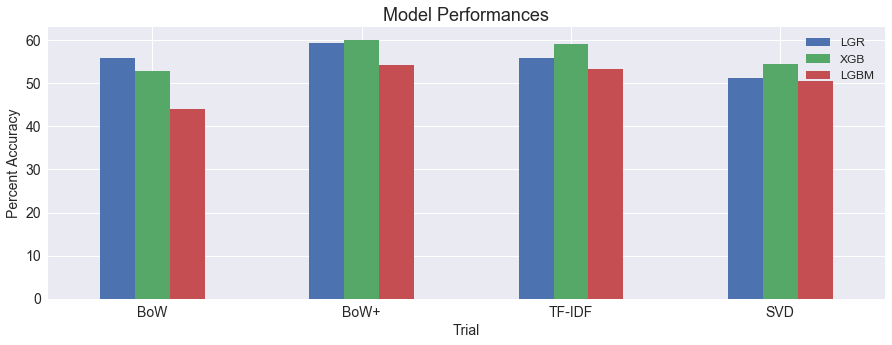

In [210]:
#Graph of model performances for my report

Trial = ['BoW', 'BoW+', 'TF-IDF', 'SVD']
lgr = [55.7, 59.2, 55.8, 51.2]
xgb = [52.7, 60.0, 59.0, 54.4]
lgbm= [44.1, 54.3, 53.3, 50.4]

modelperf = pd.DataFrame(np.c_[lgr, xgb, lgbm], index=Trial)

ax = modelperf.plot.bar(rot=0, figsize=(15,5))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Percent Accuracy', fontsize=14)
plt.xlabel('Trial', fontsize=14)
plt.title('Model Performances', fontsize=18)
ax.legend(['LGR', 'XGB', 'LGBM'], loc='upper right', fontsize=12)

plt.show()